In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.append("..")
from utils import (
    filter_noisy_genes,
    generate_k_fold,
    load_model,
    read_aws_h5ad,
    set_seed,
    write_adata_to_s3,
)

set_seed(0)

Seed set


## Load Model from Checkpoint

In [ ]:
# use anndata generate by ..data_processing/norman_prior_graph_preprocessing.ipynb
unfiltered_adata = read_aws_h5ad("path to preprocessed h5ad")
adata = filter_noisy_genes(unfiltered_adata)
adata.layers["logcounts"] = adata.X.copy()
adata.X = adata.X.todense()
device = torch.device("cuda:0")
gene_network = adata.uns["sparse_gene_network"].todense()

In [4]:
# subset to powered perturbations
obs_df = pd.DataFrame(adata.obs["perturbation_name"])
category_counts = obs_df["perturbation_name"].value_counts()
filtered_categories = category_counts[category_counts >= 50].index
adata = adata[adata.obs["perturbation_name"].isin(filtered_categories)]

In [6]:
# load model from checkpoint
s3_dir = "s3://pert-spectra/PertSpectra_checkpoints/"
experiment_name = "pertspectra_norman/"
model_name = "kfold_4"
wrapper, adata = load_model(
    adata=adata,
    s3_dir=s3_dir,
    experiment_name=experiment_name,
    model_name=model_name,
    use_cell_types=False,
)

In [ ]:
# save trained PertSpectra parameters
adata.uns["SPECTRA_factors"] = wrapper.factors
adata.uns["SPECTRA_L"] = wrapper.internal_model.L
adata.uns["SPECTRA_pert_scores"] = wrapper.cell_scores

In [7]:
# reconstruct binarized perturbation matrix
pert_idx = list(wrapper.internal_model.pert_idx)
pert_labels = [x.split("_")[-1] for x in wrapper.internal_model.pert_labels]
adata.uns["Spectra_pert_labels"] = pert_labels
D = []
for i in adata.obs["perturbation_name"]:
    d = [0.0 for _ in range(len(pert_idx))]
    # add intercept
    d[-1] = 1
    if i == "control":
        d[-2] = 1.0
        D.append(d)
        continue
    guides = i.split("+")

    # pert or intergenic
    one_hot_idx = pert_labels.index(guides[0])
    d[one_hot_idx] = 1.0

    if len(guides) > 1:
        one_hot_idx = pert_labels.index(guides[1])
        d[one_hot_idx] = 1.0
    D.append(d)
D = np.stack(D).astype(np.float32)

## Reconstructed Gene Expression
- Visualize reconstructed gene expression for a single perturbation
- Save reconstructed gene expression for all heldout cells

In [16]:
wrapper.internal_model.to(torch.device("cuda:0"))

SPECTRA()

In [9]:
# train-val-test split
train_idx, val_idx, test_idx = generate_k_fold(
    adata,
    adata.X,
    adata.obs["perturbation_name"],
    fold_idx=4,
    perturbation_key="perturbation_name",
)
loss_weights = np.ones(adata.shape[0])

In [14]:
holdout_adata = adata[test_idx]
train_adata = adata[train_idx]

In [15]:
holdout_perts = "CBL"
hold_idx = [
    i
    for i, x in enumerate(holdout_adata.obs["perturbation_name"])
    if x == holdout_perts
]
X_holdout = torch.from_numpy(holdout_adata.X[hold_idx])
D_holdout = torch.from_numpy(D[hold_idx])
loss_weights_holdout = torch.from_numpy(loss_weights[hold_idx])

In [17]:
with torch.no_grad():
    loss, recon = wrapper.internal_model.loss_no_cell_types(
        X=X_holdout, D=D_holdout, loss_weights=loss_weights_holdout, forward=True
    )

In [19]:
mean_reconstruction = recon.detach().cpu().numpy().mean(axis=0)
observed = torch.from_numpy(
    holdout_adata[(holdout_adata.obs["perturbation_name"] == holdout_perts)].X
)
mean_observed = torch.mean(observed, dim=0).detach().cpu().numpy()

In [ ]:
from scipy.stats import spearmanr

spearmans = spearmanr(mean_reconstruction, mean_observed)

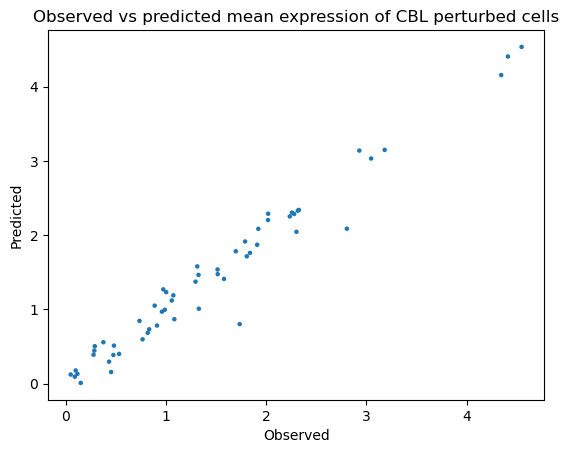

Spearman correlation: SignificanceResult(statistic=0.9697197539302803, pvalue=9.701068316902012e-35)


In [21]:
plt.scatter(
    mean_observed, mean_reconstruction, s=[5 for _ in range(len(mean_observed))]
)
plt.title(f"Observed vs predicted mean expression of {holdout_perts} perturbed cells")
plt.ylabel("Predicted")
plt.xlabel("Observed")
plt.show()
print(f"Spearman correlation: {spearmans}")

In [23]:
# get reconstruction for all heldout samples
X_holdout = torch.from_numpy(holdout_adata.X)
D_holdout = torch.from_numpy(D[test_idx])
loss_weights_holdout = torch.from_numpy(np.ones(holdout_adata.shape[0]))
recons = []
losses = []
with torch.no_grad():
    for i in range(0, len(X_holdout), 1000):
        loss, recon = wrapper.internal_model.loss_no_cell_types(
            X=X_holdout[i : i + 1000],
            D=D_holdout[i : i + 1000],
            loss_weights=loss_weights_holdout[i : i + 1000],
            forward=True,
        )
        losses.append(loss.detach().cpu().numpy())
        recons.append(recon.detach().cpu().numpy())
adata.uns["recon"] = np.concatenate(recons)
adata.uns["losses"] = np.array(losses)

## Save anndata for downstream analysis

In [24]:
# save anndata for downstream analysis
from scipy import sparse

adata.X = sparse.csr_matrix(adata.X)
write_adata_to_s3(s3_dir + experiment_name, "fold_4", adata)